In [29]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import requests # library to handle requests
import urllib.request
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

import time
import geocoder
import math

print('Libraries imported.')

Libraries imported.


### Foursquare categories

In theory, searching the top level category of "Food" in a Foursquare API would return all results.  However, in practice, I have noticed many restaurants missing from these searches, especially certain vegetarian restaurants I was hoping to find.

To remedy this, I downloaded most categories that were one level below the "Food" top level, such as American, Asian, BBQ Joint, etc. into my own csv file.

Using this list of sub-categories, I can then do a brute force collection of queries using every category, which improves the accuracy of the results.

In [30]:
foursquareCats = pd.read_csv('foursquarecats.csv', header=None)

In [31]:
foursquareCats = foursquareCats.transpose()

In [32]:
foursquareCats.rename(columns={0:'Category'}, inplace=True)
print ('Foursquare categories:' + str(foursquareCats.shape))
foursquareCats.tail()

Foursquare categories:(76, 1)


Category
71  4bf58dd8d48988d158941735
72  56aa371be4b08b9a8d573538
73  4f04af1f2fb6e1c99f3db0bb
74  52e928d0bcbc57f1066b7e96
75  4bf58dd8d48988d1d3941735

So we have 76 Foursquare restaurant categories to search every neighborhood in Jacksonville with.


### Create a list of all neighborhoods in Jacksonville, FL.
Import and parse a Wikipedia page listing all neighborhoods.

In [33]:
jaxwikiURL = 'https://en.wikipedia.org/wiki/Neighborhoods_of_Jacksonville'

page = urllib.request.urlopen(jaxwikiURL)
soup=BeautifulSoup(page, 'html.parser')

Each neighborhood name is listed in a <b>span</b> tag, using the class <b>toctext</b>.

In [34]:
jax_table=soup.find_all('span', class_='toctext')
type(jax_table)

bs4.element.ResultSet

A few neighborhoods are grouped together under one heading on the Wikipedia page. e.g. Riverside and Avondale.

If so, split that heading into two rows, one for each neighborhood.

In [35]:
jaxHoods=[]

for tempItem in jax_table:
    tempString = str(tempItem.text)
    
    if tempString.find (' and ') <0 :
        jaxHoods.append (tempString)
    else:
        twoHoods = tempString.split (" and ")
        jaxHoods.extend (twoHoods)
    
    
jaxHoods

['Regions',
 'Downtown',
 'Downtown Core',
 'LaVilla',
 'Brooklyn',
 'Southbank',
 'Riverside',
 'Avondale',
 'Springfield',
 'Eastside',
 'Oakland',
 'Fairfield',
 'San Marco',
 'St. Nicholas',
 'Ortega',
 'Mandarin',
 'Northside',
 'Brentwood',
 'Panama Park',
 'Riverview',
 'Tallulah-North Shore',
 'Westside',
 'Lake Shore',
 'Murray Hill',
 'New Town',
 'Durkeeville',
 'Arlington',
 'Sandalwood',
 'Southside',
 'Jacksonville Beaches',
 'Notes',
 'References',
 'External links']

Put all neighborhoods into dataframe.

In [36]:
jax_df = pd.DataFrame (jaxHoods , columns = ['Neighborhood'])

In [37]:
jax_df

Neighborhood
0                Regions
1               Downtown
2          Downtown Core
3                LaVilla
4               Brooklyn
5              Southbank
6              Riverside
7               Avondale
8            Springfield
9               Eastside
10               Oakland
11             Fairfield
12             San Marco
13          St. Nicholas
14                Ortega
15              Mandarin
16             Northside
17             Brentwood
18           Panama Park
19             Riverview
20  Tallulah-North Shore
21              Westside
22            Lake Shore
23           Murray Hill
24              New Town
25           Durkeeville
26             Arlington
27            Sandalwood
28             Southside
29  Jacksonville Beaches
30                 Notes
31            References
32        External links

Delete first two rows of Regions and Dowtown label (so we don't have a duplicate of Downtown). Then delete last few rows of Notes, References and External links - since those aren't neighborhood names.

In [38]:
jax_df.drop ([0,1,30,31,32], axis=0, inplace=True)
jax_df.reset_index(drop=True,inplace=True)
jax_df

Neighborhood
0          Downtown Core
1                LaVilla
2               Brooklyn
3              Southbank
4              Riverside
5               Avondale
6            Springfield
7               Eastside
8                Oakland
9              Fairfield
10             San Marco
11          St. Nicholas
12                Ortega
13              Mandarin
14             Northside
15             Brentwood
16           Panama Park
17             Riverview
18  Tallulah-North Shore
19              Westside
20            Lake Shore
21           Murray Hill
22              New Town
23           Durkeeville
24             Arlington
25            Sandalwood
26             Southside
27  Jacksonville Beaches

Next we create columns which will hold the latitude and longitude of each neighborhood in Jacksonville.  

Note: The column LatLong with hold a concatenation of the latitude and longitude - this will help us in eliminating any duplicates later on (any restaurant found twice with the same exact latitude and longitude can be safely deleted as a duplicate).

In [39]:
jax_df["Latitude"] = ""
jax_df["Longitude"] = ""
jax_df.head()

Neighborhood Latitude Longitude
0  Downtown Core                   
1        LaVilla                   
2       Brooklyn                   
3      Southbank                   
4      Riverside

## Find coordinates
For each neighborhood in Jacksonville, use ArcGIS to locate latitude and longitude coordinates.  These will then be passed into Foursquare API calls later.


In [40]:
for i in jax_df.index:
#for i in range (0, 1):

    hood_name = jax_df.iloc[i]['Neighborhood']

    # initialize your variable to None
    location = None

    #print ("Search for: " + postal_code)

    while (location is None):
        
        location=geocoder.arcgis('{}, Jacksonville, FL'.format(hood_name), out_fields="*")
        time.sleep(1)  # wait one second to not overload the geocoder engine
        
        jax_df.loc[i,'Latitude'] = location.latlng[0]
        jax_df.loc[i,'Longitude'] = location.latlng[1]
        
print ("Done loading postal code latitude and longitude...")

Done loading postal code latitude and longitude...


In [41]:
jax_df

Neighborhood Latitude Longitude
0          Downtown Core  30.3284  -81.6569
1                LaVilla  30.3308  -81.6696
2               Brooklyn   30.323  -81.6752
3              Southbank  30.1157  -81.5867
4              Riverside  30.3138  -81.6927
5               Avondale  30.3041  -81.7117
6            Springfield  30.3445  -81.6551
7               Eastside    30.34  -81.6403
8                Oakland   30.242  -81.7353
9              Fairfield  30.3498  -81.6287
10             San Marco  30.3117  -81.6605
11          St. Nicholas  30.3053  -81.6358
12                Ortega  30.2701  -81.7077
13              Mandarin  30.1593  -81.6592
14             Northside  30.5214  -81.6153
15             Brentwood  30.3592  -81.6587
16           Panama Park  30.3791  -81.6425
17             Riverview  30.4059  -81.6876
18  Tallulah-North Shore  30.3831  -81.6573
19              Westside  30.3632  -81.7145
20            Lake Shore  30.2809  -81.7261
21           Murray Hill  30.3124  -81.7218
22              New Town  30.3396    -81.68
23           Durkeeville  30.3452  -81.6723
24             Arlington  30.3358  -81.6031
25            Sandalwood  30.3175  -81.5179
26             Southside  30.3169  -81.6547
27  Jacksonville Beaches  30.4586  -81.4134

Call Foursquare API to retrieve all restaurants for every neighborhood.  Then find all vegetarian restaurants.  Then We will then how many vegetarian restaurants vs the total of all types of restaurants.

In [42]:
CLIENT_ID = 'LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY' # your Foursquare ID
CLIENT_SECRET = '2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY
CLIENT_SECRET:2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ


In [43]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [44]:
# This function will do a Foursquare search for each category.
# using /venues/explore will allow the offset parameter in subsequent searches to page through more results.

# all results are appended onto a dataframe
def getFoursquareResults (foursq_cat, lat, long, hoodName, dframe):
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    lat, 
    long,
    radius, 
    LIMIT,
    foursq_cat)

    results = requests.get(url).json()
    
    try:
        totalResults = results['response']['totalResults']
    
    except:
        print ("Failed getting totalResults. Category:" + str(foursq_cat))
        print (results)
    else:
        if totalResults >0:
        
            offsetNumber = 0
            resultsLeft = totalResults
        
            while resultsLeft >0:
        
            #print ('resultsLeft:' + str(resultsLeft))
                    
                # offset by 50 each search, then combine all results into one dataframe
                urlOffset = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&offset={}'.format(
                    CLIENT_ID, 
                    CLIENT_SECRET, 
                    VERSION, 
                    lat, 
                    long, 
                    radius, 
                    LIMIT,
                    foursq_cat,
                    offsetNumber)
            
                resultsTemp = requests.get(urlOffset).json()
                
                # sometimes the pagination doesnt work as intended.. e.g. a category returns 52 results, 
                # but offset=50 returns nothing
            
                try:
                    venuesOffset = resultsTemp['response']['groups'][0]['items']
        
                except:
                    print(urlOffset)
                    print ('Error: Cant find groups in results.' )
                else:
                    
                    nearbyvenuesTemp = json_normalize(venuesOffset) # flatten JSON

                #print (nearbyvenuesTemp)
                    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
                    try:
                        # filter columns
                        nearbyvenuesTemp = nearbyvenuesTemp.loc[:, filtered_columns]
                    except:
                        print(urlOffset)
                        print ('Error:' + nearbyvenuesTemp)
                    else:
                        # filter the category for each row
                        nearbyvenuesTemp['venue.categories'] = nearbyvenuesTemp.apply(get_category_type, axis=1)

                        # clean columns
                        nearbyvenuesTemp.columns = [col.split(".")[-1] for col in nearbyvenuesTemp.columns]
    
                        nearbyvenuesTemp['Neighborhood'] = hoodName
        
                        dframe = pd.concat([dframe , nearbyvenuesTemp])       
            
                    offsetNumber = offsetNumber + 50
                    resultsLeft = resultsLeft - 50

    
    return dframe

Start looping through every neighborhood in Jacksonville, then loop through every food category to try to find every restaurant in each neighborhood

In [45]:
allRestaurants_df = pd.DataFrame ( columns = ['name','categories','lat','lng','Neighborhood'])
allRestaurants_df

Empty DataFrame
Columns: [name, categories, lat, lng, Neighborhood]
Index: []

In [46]:
# result will all be in allRestaurants_df
#-------------------------------------------------

LIMIT = 50 # limit of number of venues returned by Foursquare API

radius = 8000 # define radius
 
# For every neighborhood, search for all restaurants. 
# Concatenate them all, then remove duplicates later just in case the same restaurant shows up in multiple neighborhoods.

for i in jax_df.index:
#for i in range(2):
    
    print ("Searching restaurants in: " + hood_name)
    
    # For each neighborhood, loop through every food category.
    for catIndex in foursquareCats.index:
        #print ('Trying this category: ' + foursquareCats.loc[catIndex, 'Category'])
    
        hood_lat = jax_df.loc[i, 'Latitude']
        hood_long = jax_df.loc[i, 'Longitude']
        hood_name = jax_df.loc[i, 'Neighborhood']
    
        allRestaurants_df = getFoursquareResults (foursquareCats.loc[catIndex, 'Category'], hood_lat, hood_long, hood_name, allRestaurants_df)


    
    

Searching restaurants in: Jacksonville Beaches


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Downtown Core
Searching restaurants in: LaVilla
Searching restaurants in: Brooklyn
Searching restaurants in: Southbank
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.31376000000006,-81.69272999999998&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Riverside
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.304070000000024,-81.71174999999994&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Avondale
Searching restaurants in: Springfield
Searching restaurants in: Eastside
Searching restaurants in: Oakland
Searching restaurants in: Fairfield
Searching restaurants in: San Marco
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.305250000000058,-81.63577999999995&radius=8000&limit=50&categoryId=4bf58dd8d48988d16a941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: St. Nicholas
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.270060000000058,-81.70773999999994&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Ortega
Searching restaurants in: Mandarin
Searching restaurants in: Northside
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.35919000000007,-81.65865999999994&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Brentwood
Searching restaurants in: Panama Park
Searching restaurants in: Riverview
Searching restaurants in: Tallulah-North Shore
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.36317646972792,-81.71448745612398&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Westside
Searching restaurants in: Lake Shore
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.312430000000063,-81.72175999999996&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Murray Hill
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.339560000000063,-81.68004999999994&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: New Town
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.34522000000004,-81.67233999999996&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Durkeeville
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.335750000000075,-81.60306999999995&radius=8000&limit=50&categoryId=4bf58dd8d48988d109941735&offset=0
Error: Cant find groups in results.
Searching restaurants in: Arlington
https://api.foursquare.com/v2/venues/explore?&client_id=LAVDU5UJOSC0YQ4ECB2CG5QCNQ2BVJBNIXGCQAPCLMMMTNVY&client_secret=2NDO1TGT3BDG4YCCWYFELX4FDA3URWP10EOSSCVQPOOAVRYJ&v=20180605&ll=30.317480000000046,-81.51792999999998&radius=8000&limit=50&categoryId=4bf58dd8d48988d16d941735&offset=50
Empty DataFrame
Columns: []
Index: []


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Searching restaurants in: Sandalwood
Searching restaurants in: Southside


Error handling is necessary to ignore queries returning zero results.

Additionally, the Foursquare API has inconsistent behavior.  For example a search query might return with a total of 53 results.  In order to discover all 53 results, two queries are made.  The first query returns the first 50 results, but the subsquent query using the <b>offset=50</b> parameter fails to return the last 3 results.

Any empty result query is ignored, and the search moves on to the next Foursquare category or Jacksonville neighborhood.

In [47]:
allRestaurants_df.head()

name           categories        lat        lng  \
0     bb's restaurant and bar  American Restaurant  30.315882 -81.654662   
1    Ruth's Chris Steak House  American Restaurant  30.320061 -81.657896   
2  Desert Rider Sandwich Shop  American Restaurant  30.328769 -81.659853   
3         Super Food and Brew  American Restaurant  30.327037 -81.657392   
4                     Taverna  American Restaurant  30.303976 -81.654674   

    Neighborhood  
0  Downtown Core  
1  Downtown Core  
2  Downtown Core  
3  Downtown Core  
4  Downtown Core

In [48]:
allRestaurants_df.shape

(30752, 5)

Before removing duplicates, the dataframe containing the search results has over 30,000 entries.

Combine a restaurant's latitude and longtitude into one long string to use as a key to compare to remove duplicates.

In [49]:
allRestaurants_df['LatLong'] = allRestaurants_df['lat'].astype(str) + allRestaurants_df['lng'].astype(str)

Remove duplicates in case the same restaurant appeared in multiple searches.  If a restaurant has the exact latitude and longtitude then we know it's a duplicate.

In [50]:
allRestaurants_df = allRestaurants_df.drop_duplicates(subset='LatLong', keep='first')
allRestaurants_df.reset_index(drop=True,inplace=True)


In [51]:
allRestaurants_df.tail()

name          categories        lat        lng  \
2730                   Spam Factory      Sandwich Place  30.389156 -81.411634   
2731     Safe Harbor Seafood Market         Fish Market  30.390569 -81.432614   
2732  Sandollar Restaurant & Marina  Seafood Restaurant  30.397428 -81.416166   
2733                        Sharkys         Snack Place  30.407137 -81.414640   
2734               Vending Machines         Snack Place  30.390813 -81.397110   

              Neighborhood                               LatLong  
2730  Jacksonville Beaches               30.38915562-81.41163365  
2731  Jacksonville Beaches   30.39056857394266-81.43261350330806  
2732  Jacksonville Beaches  30.397427867101914-81.41616608460617  
2733  Jacksonville Beaches                    30.407137-81.41464  
2734  Jacksonville Beaches                    30.390813-81.39711

After removing duplicates, the group of all restaurants is reduced to approx 2700 entries.

In [52]:
allRestaurants_df.groupby(['categories']).count()

name  lat  lng  Neighborhood  LatLong
categories                                                            
American Restaurant               300  300  300           300      300
Arepa Restaurant                    1    1    1             1        1
Argentinian Restaurant              1    1    1             1        1
Asian Restaurant                   61   61   61            61       61
Australian Restaurant               4    4    4             4        4
BBQ Joint                          79   79   79            79       79
Bagel Shop                         10   10   10            10       10
Bakery                            102  102  102           102      102
Bar                                10   10   10            10       10
Belgian Restaurant                  1    1    1             1        1
Bistro                              9    9    9             9        9
Bookstore                           1    1    1             1        1
Bowling Alley                       1    1    1             1        1
Brazilian Restaurant                4    4    4             4        4
Breakfast Spot                     49   49   49            49       49
Brewery                             2    2    2             2        2
Bubble Tea Shop                     3    3    3             3        3
Buffet                              2    2    2             2        2
Burger Joint                       42   42   42            42       42
Burrito Place                       6    6    6             6        6
Cafeteria                           7    7    7             7        7
Café                               84   84   84            84       84
Cajun / Creole Restaurant          14   14   14            14       14
Candy Store                         1    1    1             1        1
Cantonese Restaurant                1    1    1             1        1
Caribbean Restaurant               14   14   14            14       14
Casino                              1    1    1             1        1
Caucasian Restaurant                1    1    1             1        1
Chinese Restaurant                103  103  103           103      103
Cocktail Bar                        1    1    1             1        1
Coffee Shop                        76   76   76            76       76
College Cafeteria                   5    5    5             5        5
Colombian Restaurant                1    1    1             1        1
Comfort Food Restaurant             7    7    7             7        7
Convenience Store                  10   10   10            10       10
Creperie                            2    2    2             2        2
Cuban Restaurant                    3    3    3             3        3
Cupcake Shop                        2    2    2             2        2
Deli / Bodega                      38   38   38            38       38
Dessert Shop                       20   20   20            20       20
Dim Sum Restaurant                  2    2    2             2        2
Diner                              15   15   15            15       15
Doctor's Office                     1    1    1             1        1
Doner Restaurant                    1    1    1             1        1
Donut Shop                         46   46   46            46       46
Dumpling Restaurant                 3    3    3             3        3
Eastern European Restaurant         1    1    1             1        1
Ethiopian Restaurant                1    1    1             1        1
Falafel Restaurant                  3    3    3             3        3
Farmers Market                      1    1    1             1        1
Fast Food Restaurant              278  278  278           278      278
Filipino Restaurant                 4    4    4             4        4
Fish & Chips Shop                   2    2    2             2        2
Fish Market                         1    1    1             1        1
Food                               13   13   13          

Next, search Foursquare for only those restaurants classified mainly as <b>Vegetarian / Vegan</b>.

In some cases a restaurant can have multiple sub-categories, but this gives a clear picture of those restaurants making a concerted effort to target a vegetarian customer base.

In [53]:
# category for just Vegetarian restaurants
vegCategory = '4bf58dd8d48988d1d3941735'

vegRestaurants_df = pd.DataFrame ( columns = ['name','categories','lat','lng','Neighborhood'])
vegRestaurants_df 

Empty DataFrame
Columns: [name, categories, lat, lng, Neighborhood]
Index: []

Call the getFoursquareResults function for every neighborhood, searching for only the vegetarian Foursquare category.

In [54]:

LIMIT = 500 # limit of number of venues returned by Foursquare API

radius = 8000 # define radius in meters.  8,000 meters is approx 5 miles.

# For every neighborhood, search for all restaurants. 
# Concatenate them all, then remove duplicates later just in case the same restaurant shows up in multiple neighborhoods.

for i in jax_df.index:
    
    hood_lat = jax_df.loc[i, 'Latitude']
    hood_long = jax_df.loc[i, 'Longitude']
    hood_name = jax_df.loc[i, 'Neighborhood']
    
    vegRestaurants_df = getFoursquareResults (vegCategory, hood_lat, hood_long, hood_name, vegRestaurants_df)

vegRestaurants_df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


name                     categories        lat  \
0  Grassroots Natural Market                  Grocery Store  30.313987   
1                      Orsay              French Restaurant  30.300354   
2   Biggie’s Pizza Riverside  Vegetarian / Vegan Restaurant  30.314184   
3       The Murray Hillbilly  Vegetarian / Vegan Restaurant  30.311316   
4              Jax City Café                 Sandwich Place  30.326704   

         lng   Neighborhood  
0 -81.681832  Downtown Core  
1 -81.709998  Downtown Core  
2 -81.680900  Downtown Core  
3 -81.717415  Downtown Core  
4 -81.656481  Downtown Core

As before, since the neighborhood searches may have overlapped each other, there may be duplicates in the resulting dataframe.

Create a unique identifier by combining the latitude and longitude columns.  Any entry with the same exact latitude and longitude may be removed as a duplicate.

In [55]:
vegRestaurants_df['LatLong'] = vegRestaurants_df['lat'].astype(str) + vegRestaurants_df['lng'].astype(str)

In [56]:
vegRestaurants_df = vegRestaurants_df.drop_duplicates(subset='LatLong', keep='first')
vegRestaurants_df.reset_index(drop=True,inplace=True)

In [57]:
vegRestaurants_df

name                     categories        lat  \
0   Grassroots Natural Market                  Grocery Store  30.313987   
1                       Orsay              French Restaurant  30.300354   
2    Biggie’s Pizza Riverside  Vegetarian / Vegan Restaurant  30.314184   
3        The Murray Hillbilly  Vegetarian / Vegan Restaurant  30.311316   
4               Jax City Café                 Sandwich Place  30.326704   
5           Sand Wedge Salads  Vegetarian / Vegan Restaurant  30.104504   
6               Jim's Produce  Vegetarian / Vegan Restaurant  30.158062   
7        Butterflies Pastries  Vegetarian / Vegan Restaurant  30.127820   
8                  Sabra Cafe  Vegetarian / Vegan Restaurant  30.145702   
9         fresh start veggies  Vegetarian / Vegan Restaurant  30.082348   
10                   Your Pie  Vegetarian / Vegan Restaurant  30.102793   
11                Veganville!  Vegetarian / Vegan Restaurant  30.215779   
12           Community Loaves  Vegetarian / Vegan Restaurant  30.316404   
13                Chase Foods  Vegetarian / Vegan Restaurant  30.457974   
14                 Seasons 52  Vegetarian / Vegan Restaurant  30.251833   
15                   Your Pie  Vegetarian / Vegan Restaurant  30.259006   
16                   Your Pie  Vegetarian / Vegan Restaurant  30.288259   
17            Mellow Mushroom                    Pizza Place  30.265157   
18          True Food Kitchen  Vegetarian / Vegan Restaurant  30.252591   

          lng   Neighborhood                               LatLong  
0  -81.681832  Downtown Core  30.313986963468896-81.68183179987105  
1  -81.709998  Downtown Core  30.300353736222007-81.70999817992787  
2  -81.680900  Downtown Core                     30.314184-81.6809  
3  -81.717415  Downtown Core                   30.311316-81.717415  
4  -81.656481  Downtown Core    30.3267043128439-81.65648132857369  
5  -81.579407      Southbank  30.104503631591797-81.57940673828125  
6  -81.598791      Southbank                   30.158062-81.598791  
7  -81.532144      Southbank                    30.12782-81.532144  
8  -81.633997      Southbank  30.145702406973328-81.63399696350098  
9  -81.639980      Southbank                    30.082348-81.63998  
10 -81.518129      Southbank                 30.1027926-81.5181288  
11 -81.733358        Oakland  30.215779227022026-81.73335765781809  
12 -81.675827      Fairfield                   30.316404-81.675827  
13 -81.578937      Northside  30.457974027344232-81.57893697072207  
14 -81.526069     Sandalwood  30.251832867897047-81.52606896806377  
15 -81.554340     Sandalwood                 30.2590055-81.5543402  
16 -81.462877     Sandalwood                 30.2882587-81.4628773  
17 -81.555150     Sandalwood                    30.265157-81.55515  
18 -81.525043     Sandalwood                   30.252591-81.525043

A search of the Foursquare data currently returns 19 restaurants under the <b>Vegetarian / Vegan</b> sub-category.

### K Means clustering

Find optimal number of clusters, based on the dataframe containing the entire set of latitude and longitude data.

In [58]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

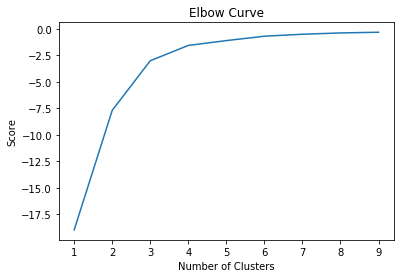

In [59]:
K_clusters = range(1,10)

kmeans = [KMeans(n_clusters=i) for i in K_clusters]

Y_axis = allRestaurants_df[['lat']]
X_axis = allRestaurants_df[['lng']]

score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Based on the elbow method, the optimal number of cluster is 3.

In [60]:
allRestaurants_df[allRestaurants_df.columns[2:4]]

lat        lng
0     30.315882 -81.654662
1     30.320061 -81.657896
2     30.328769 -81.659853
3     30.327037 -81.657392
4     30.303976 -81.654674
5     30.312739 -81.680895
6     30.323595 -81.671219
7     30.303552 -81.653711
8     30.314095 -81.681251
9     30.314664 -81.654879
10    30.323872 -81.655247
11    30.291141 -81.648784
12    30.314116 -81.677943
13    30.339286 -81.654439
14    30.303979 -81.630394
15    30.313908 -81.696130
16    30.296282 -81.704620
17    30.307085 -81.621508
18    30.307504 -81.688752
19    30.304927 -81.633793
20    30.318219 -81.653720
21    30.325913 -81.658479
22    30.296670 -81.704052
23    30.272277 -81.704252
24    30.289822 -81.713666
25    30.270251 -81.620947
26    30.261295 -81.644067
27    30.274970 -81.650905
28    30.321416 -81.729676
29    30.308905 -81.734867
30    30.308513 -81.654581
31    30.285783 -81.720153
32    30.324582 -81.660349
33    30.291598 -81.626744
34    30.288829 -81.722467
35    30.362857 -81.606164
36    30.296642 -81.703868
37    30.293199 -81.605445
38    30.312679 -81.694765
39    30.330036 -81.659935
40    30.327283 -81.660916
41    30.300354 -81.709998
42    30.325206 -81.659687
43    30.324871 -81.659932
44    30.325943 -81.661860
45    30.329601 -81.663536
46    30.318120 -81.658639
47    30.317736 -81.658356
48    30.317660 -81.653820
49    30.324994 -81.660158
50    30.317391 -81.663383
51    30.325038 -81.643083
52    30.340884 -81.655376
53    30.328505 -81.672858
54    30.327694 -81.673304
55    30.315849 -81.664767
56    30.324092 -81.644977
57    30.342545 -81.675701
58    30.315359 -81.677053
59    30.263917 -81.623307
60    30.303794 -81.652688
61    30.354555 -81.653957
62    30.357369 -81.658634
63    30.300070 -81.641853
64    30.322276 -81.697574
65    30.293321 -81.642708
66    30.365954 -81.663659
67    30.303863 -81.652483
68    30.331893 -81.705416
69    30.290708 -81.633834
70    30.301869 -81.615467
71    30.343308 -81.602360
72    30.296168 -81.613135
73    30.372026 -81.687730
74    30.330684 -81.597191
75    30.281728 -81.650723
76    30.276346 -81.604543
77    30.306853 -81.716480
78    30.288553 -81.608904
79    30.292170 -81.602974
80    30.328478 -81.586281
81    30.335029 -81.585666
82    30.392007 -81.647967
83    30.320106 -81.722556
84    30.313006 -81.580321
85    30.271119 -81.636561
86    30.310041 -81.693403
87    30.286134 -81.720035
88    30.272533 -81.608960
89    30.381438 -81.694581
90    30.296409 -81.730033
91    30.300222 -81.710390
92    30.313327 -81.681008
93    30.287034 -81.713606
94    30.324398 -81.659733
95    30.319616 -81.656855
96    30.323557 -81.644742
97    30.322350 -81.677352
98    30.303994 -81.652137
99    30.295773 -81.704635
100   30.315113 -81.680404
101   30.327757 -81.656875
102   30.313065 -81.695645
103   30.328191 -81.659499
104   30.315315 -81.682374
105   30.386621 -81.676798
106   30.311247 -81.681344
107   30.304135 -81.655386
108   30.311823 -81.680578
109   30.313675 -81.680946
110   30.311885 -81.680742
111   30.309944 -81.693440
112   30.314658 -81.680685
113   30.309046 -81.733780
114   30.308900 -81.732995
115   30.318492 -81.655589
116   30.310078 -81.694399
117   30.304128 -81.654928
118   30.296040 -81.704596
119   30.341941 -81.654696
120   30.308297 -81.714008
121   30.279012 -81.602666
122   30.324794 -81.659840
123   30.270429 -81.610860
124   30.391804 -81.680332
125   30.309503 -81.660346
126   30.287916 -81.721172
127   30.280988 -81.718225
128   30.315727 -81.689385
129   30.260406 -81.643610
130   30.352146 -81.595150
131   30.276607 -81.603178
132   30.280742 -81.718542
133   30.315072 -81.682239
134   30.356364 -81.674395
135   30.324363 -81.659702
136   30.291444 -81.626258
137   30.316088 -81.655037
138   30.311951 -81.602068
139   30.314980 -81.598605
140   30.278544 -81.602348
141   30.278643 -81.627828
142   30.292047 -81.605117
143   30.276787 -81.626448
144   30.351866 -81.593461
145   30.313676 -81.680848
146   30.365084 -81.596565
147   30.338161 

Create three clusters based on the latitude and longitude data.

In [61]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')

kmeans.fit(allRestaurants_df[allRestaurants_df.columns[2:4]]) # Compute k-means clustering.

allRestaurants_df['cluster_label'] = kmeans.fit_predict(allRestaurants_df[allRestaurants_df.columns[2:4]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(allRestaurants_df[allRestaurants_df.columns[2:4]]) # Labels of each point
allRestaurants_df.head()

name           categories        lat        lng  \
0     bb's restaurant and bar  American Restaurant  30.315882 -81.654662   
1    Ruth's Chris Steak House  American Restaurant  30.320061 -81.657896   
2  Desert Rider Sandwich Shop  American Restaurant  30.328769 -81.659853   
3         Super Food and Brew  American Restaurant  30.327037 -81.657392   
4                     Taverna  American Restaurant  30.303976 -81.654674   

    Neighborhood                              LatLong  cluster_label  
0  Downtown Core  30.315881758918543-81.6546624104728              1  
1  Downtown Core                 30.3200609-81.657896              1  
2  Downtown Core  30.32876871022726-81.65985345840454              1  
3  Downtown Core                30.3270375-81.6573919              1  
4  Downtown Core  30.30397646193031-81.65467433490483              1

The 2700 or so restaurants are grouped into three clusters, each one labeled 0, 1 or 2.

In [73]:
allRestaurants_df.groupby(['cluster_label']).count()

name  categories   lat   lng  Neighborhood  LatLong
cluster_label                                                     
0               931         931   931   931           931      931
1              1125        1124  1125  1125          1125     1125
2               679         678   679   679           679      679

At this point, all 2700 restaurants have been assigned a cluster.  However, we would like to separate all Vegetarian restaurants (and their cluster label) into a different dataframe in order to simplify our discovery.

There are two dataframes:
allRestaurants_df - containing 2700 restaurants (with cluster labels)
vegRestaurants_df - containing 19 vegetarian restaurants (without cluster labels)

Since vegRestaurants_df should be a subset of allRestaurants_df, merging the two based on the latitude/longitude value should match each vegetarian restaurant with its corresponding cluster label.


In [63]:
vegRestaurants_df.head()

name                     categories        lat  \
0  Grassroots Natural Market                  Grocery Store  30.313987   
1                      Orsay              French Restaurant  30.300354   
2   Biggie’s Pizza Riverside  Vegetarian / Vegan Restaurant  30.314184   
3       The Murray Hillbilly  Vegetarian / Vegan Restaurant  30.311316   
4              Jax City Café                 Sandwich Place  30.326704   

         lng   Neighborhood                               LatLong  
0 -81.681832  Downtown Core  30.313986963468896-81.68183179987105  
1 -81.709998  Downtown Core  30.300353736222007-81.70999817992787  
2 -81.680900  Downtown Core                     30.314184-81.6809  
3 -81.717415  Downtown Core                   30.311316-81.717415  
4 -81.656481  Downtown Core    30.3267043128439-81.65648132857369

In [64]:
allRestaurants_df.head()

name           categories        lat        lng  \
0     bb's restaurant and bar  American Restaurant  30.315882 -81.654662   
1    Ruth's Chris Steak House  American Restaurant  30.320061 -81.657896   
2  Desert Rider Sandwich Shop  American Restaurant  30.328769 -81.659853   
3         Super Food and Brew  American Restaurant  30.327037 -81.657392   
4                     Taverna  American Restaurant  30.303976 -81.654674   

    Neighborhood                              LatLong  cluster_label  
0  Downtown Core  30.315881758918543-81.6546624104728              1  
1  Downtown Core                 30.3200609-81.657896              1  
2  Downtown Core  30.32876871022726-81.65985345840454              1  
3  Downtown Core                30.3270375-81.6573919              1  
4  Downtown Core  30.30397646193031-81.65467433490483              1

In [65]:
vegLabeled = pd.merge (vegRestaurants_df, allRestaurants_df, on='LatLong', how='left')

In [66]:
vegLabeled.drop(['name_x', 'categories_x','lat_x','lng_x','Neighborhood_x'], axis=1, inplace=True)
vegLabeled.head()

LatLong                     name_y  \
0  30.313986963468896-81.68183179987105  Grassroots Natural Market   
1  30.300353736222007-81.70999817992787                      Orsay   
2                     30.314184-81.6809   Biggie’s Pizza Riverside   
3                   30.311316-81.717415       The Murray Hillbilly   
4    30.3267043128439-81.65648132857369              Jax City Café   

                    categories_y      lat_y      lng_y Neighborhood_y  \
0                  Grocery Store  30.313987 -81.681832  Downtown Core   
1              French Restaurant  30.300354 -81.709998  Downtown Core   
2                    Pizza Place  30.314184 -81.680900  Downtown Core   
3  Vegetarian / Vegan Restaurant  30.311316 -81.717415  Downtown Core   
4              French Restaurant  30.326704 -81.656481  Downtown Core   

   cluster_label  
0              1  
1              1  
2              1  
3              1  
4              1

Clean up column names.

In [67]:
vegLabeled.columns = [col.split("_")[0] for col in vegLabeled.columns]
vegLabeled.head()

LatLong                       name  \
0  30.313986963468896-81.68183179987105  Grassroots Natural Market   
1  30.300353736222007-81.70999817992787                      Orsay   
2                     30.314184-81.6809   Biggie’s Pizza Riverside   
3                   30.311316-81.717415       The Murray Hillbilly   
4    30.3267043128439-81.65648132857369              Jax City Café   

                      categories        lat        lng   Neighborhood  cluster  
0                  Grocery Store  30.313987 -81.681832  Downtown Core        1  
1              French Restaurant  30.300354 -81.709998  Downtown Core        1  
2                    Pizza Place  30.314184 -81.680900  Downtown Core        1  
3  Vegetarian / Vegan Restaurant  30.311316 -81.717415  Downtown Core        1  
4              French Restaurant  30.326704 -81.656481  Downtown Core        1

In [68]:
vegLabeled.groupby(['cluster']).count()

LatLong  name  categories  lat  lng  Neighborhood
cluster                                                   
0              5     5           5    5    5             5
1              7     7           7    7    7             7
2              7     7           7    7    7             7

In [69]:
vegLabeled.groupby(['cluster','name']).count()

LatLong  categories  lat  lng  Neighborhood
cluster name                                                                  
0       Kairos Nutrition Bar             1           1    1    1             1
        Mellow Mushroom                  1           1    1    1             1
        Seasons 52                       1           1    1    1             1
        True Food Kitchen                1           1    1    1             1
        Your Pie                         1           1    1    1             1
1       Biggie’s Pizza Riverside         1           1    1    1             1
        Chase Foods                      1           1    1    1             1
        Community Loaves                 1           1    1    1             1
        Grassroots Natural Market        1           1    1    1             1
        Jax City Café                    1           1    1    1             1
        Orsay                            1           1    1    1             1
        The Murray Hillbilly             1           1    1    1             1
2       Butterflies Pastries             1           1    1    1             1
        Jim's Produce                    1           1    1    1             1
        Sabra Cafe                       1           1    1    1             1
        Sand Wedge Salads                1           1    1    1             1
        Veganville!                      1           1    1    1             1
        Your Pie                         1           1    1    1             1
        fresh start veggies              1           1    1    1             1

### Create maps to help visualize the results

First add all restaurants to a map of Jacksonsville.  Each of the three clusters will be shown by its own color.

Calculate the latitude for the center of Jacksonville for the map.

In [70]:
# initialize your variable to None
location = None

    #print ("Search for: " + postal_code)

while (location is None):
        
    location=geocoder.arcgis('Jacksonville, FL', out_fields="*")
               
    jax_lat = location.latlng[0]
    jax_long = location.latlng[1]
        #jax_df.loc[i,'LatLong'] = str(location.latlng[0]) + str(location.latlng[1])
        
print ("Jax lat: " + str(jax_lat) + "  and Jax long: " + str(jax_long))

Jax lat: 30.331470000000024  and Jax long: -81.65621999999996


Create map, then add clustered restaurants

In [71]:
n_clusters = 3

allRestaurants_df['cluster_label'] = allRestaurants_df['cluster_label'].astype(int)

map_clusters = folium.Map(location=[jax_lat, jax_long], zoom_start=11)
# set color scheme for the clusters

x = np.arange(n_clusters)

#ys = [i + x + (i*x)**2 for i in range(n_clusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]
rainbow = ['#b30000', '#000099', '#003300']

for cluster in range(0,n_clusters): 
    group = folium.FeatureGroup(name='<span style=\\"color: {0};\\">{1}</span>'.format(rainbow[cluster-1],cluster))
    for lat, lon, poi, label in zip(allRestaurants_df['lat'], allRestaurants_df['lng'], allRestaurants_df['name'], allRestaurants_df['cluster_label']):
        if int(label) == cluster: 
            label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
            folium.CircleMarker(
                (lat, lon),
                radius=5,
                popup=label,
                color=rainbow[cluster-1],
                fill=True,
                fill_color=rainbow[cluster-1],
                fill_opacity=0.7).add_to(group)
    group.add_to(map_clusters)
#folium.map.LayerControl('topright', collapsed=False).add_to(map_clusters)
#map_clusters.save(outfile= "map_clusters.html")
map_clusters

### Add Vegetarian restaurants to map

The small group of vegetarian restaurant are added in yellow to distinguish from the collection of all restaurants.

In [72]:
# add all vegetarian restaurants as yellow circle markers
for lat, lng, label, clusterName in zip(vegLabeled.lat, vegLabeled.lng, vegLabeled.name, vegLabeled.cluster):
    newLabel =folium.Popup(str(label) + ' Cluster ' + str(clusterName), parse_html=True)
      
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        color='#ffff00',
        popup=newLabel,
        fill = True,
        fill_color='#ffff00',
        fill_opacity=0.6
    ).add_to(map_clusters)
    
map_clusters